In [63]:
%load_ext autoreload
%autoreload

# !nrnivmodl mechanisms
import bluepyopt as bpopt
import bluepyopt.ephys as ephys

import pprint
pp = pprint.PrettyPrinter(indent=2)

import matplotlib.pyplot as plt
%matplotlib notebook
import MEAutility as mu

import json
import numpy
import time
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
import LFPy
print(LFPy.__file__)

/Users/abuccino/Documents/Codes/modeling/LFPy_fork/LFPy/LFPy/__init__.py


In [ ]:
def get_snippets(trace, times, snip_times, snippet_len):
    # Default implementation
    if isinstance(snippet_len, (tuple, list, np.ndarray)):
        snippet_len_before = int(snippet_len[0])
        snippet_len_after = int(snippet_len[1])
    else:
        snippet_len_before = int((snippet_len + 1) / 2)
        snippet_len_after = int(snippet_len - snippet_len_before)
        
    num_snippets = len(snip_times)
    num_frames = len(times)
    snippet_len_total = int(snippet_len_before + snippet_len_after)
    snippets = np.zeros((num_snippets, num_channels, snippet_len_total), dtype=trace.dtype)

    for i in range(num_snippets):
        snippet_chunk = np.zeros((num_channels, snippet_len_total), dtype=trace.dtype)
        if 0 <= reference_frames[i] < num_frames:
            snippet_range = np.array([int(reference_frames[i]) - snippet_len_before,
                                      int(reference_frames[i]) + snippet_len_after])
            snippet_buffer = np.array([0, snippet_len_total], dtype='int')
            # The following handles the out-of-bounds cases
            if snippet_range[0] < 0:
                snippet_buffer[0] -= snippet_range[0]
                snippet_range[0] -= snippet_range[0]
            if snippet_range[1] >= num_frames:
                snippet_buffer[1] -= snippet_range[1] - num_frames
                snippet_range[1] -= snippet_range[1] - num_frames
            snippet_chunk[:, snippet_buffer[0]:snippet_buffer[1]] = self.get_traces(channel_ids=channel_ids,
                                                                                    start_frame=snippet_range[0],
                                                                                    end_frame=snippet_range[1])
        snippets[i] = snippet_chunk
    return snippets


In [4]:
# # Define electrode
# sq_mea = mu.return_mea('SqMEA-10-15')
# sq_mea.rotate([0, 1, 0], 90)
# sq_mea.move([0, 0, -50])

# electrode = LFPy.RecExtElectrode(probe=sq_mea, method='pointsource')

In [154]:
mea_positions = [[0, 0, 50], [0, 600., 50], [0, 800., 50]]
probe = mu.return_mea(info={'pos': mea_positions, 'center': False, 'plane': 'xy'})
electrode = LFPy.RecExtElectrode(probe=probe, method='linesource')

In [155]:
import l5pc_model
import l5pc_evaluator

morphology = ephys.morphologies.NrnFileMorphology('morphology/C060114A7.asc', do_replace_axon=True)
param_configs = json.load(open('config/parameters.json'))
parameters = l5pc_model.define_parameters()
mechanisms = l5pc_model.define_mechanisms()

l5pc_cell = ephys.models.LFPyCellModel('l5pc', 
                                       v_init=-65., 
                                       morph=morphology, 
                                       mechs=mechanisms, 
                                       params=parameters)

param_names = [param.name for param in l5pc_cell.params.values() if not param.frozen]      

# fitness_protocols = l5pc_evaluator.define_protocols(electrode) #electrode
fitness_protocols = l5pc_evaluator.define_protocols() #electrode

feature_configs = json.load(open('config/features.json'))
fitness_calculator = l5pc_evaluator.define_fitness_calculator(fitness_protocols)

# sim = ephys.simulators.LFPySimulator(LFPyCellModel=l5pc_cell, electrode=electrode)
sim = ephys.simulators.LFPySimulator(LFPyCellModel=l5pc_cell, cvode_active=True)
# sim = ephys.simulators.LFPySimulator(LFPyCellModel=l5pc_cell, cvode_active=False, electrode=electrode)

evaluator = ephys.evaluators.CellEvaluator(                                          
                cell_model=l5pc_cell,                                                       
                param_names=param_names,                                                    
                fitness_protocols=fitness_protocols,                                        
                fitness_calculator=fitness_calculator,                                      
                sim=sim) 

In [156]:
fitness_protocols

{'bAP': <bluepyopt.ephys.protocols.SweepProtocol at 0x15351e780>,
 'Step3': <bluepyopt.ephys.protocols.SweepProtocol at 0x15351e048>,
 'Step2': <bluepyopt.ephys.protocols.SweepProtocol at 0x15351e940>,
 'Step1': <bluepyopt.ephys.protocols.SweepProtocol at 0x15351e0f0>}

In [157]:
release_params = {
    'gNaTs2_tbar_NaTs2_t.apical': 0.026145,
    'gSKv3_1bar_SKv3_1.apical': 0.004226,
    'gImbar_Im.apical': 0.000143,
    'gNaTa_tbar_NaTa_t.axonal': 3.137968,
    'gK_Tstbar_K_Tst.axonal': 0.089259,
    'gamma_CaDynamics_E2.axonal': 0.002910,
    'gNap_Et2bar_Nap_Et2.axonal': 0.006827,
    'gSK_E2bar_SK_E2.axonal': 0.007104,
    'gCa_HVAbar_Ca_HVA.axonal': 0.000990,
    'gK_Pstbar_K_Pst.axonal': 0.973538,
    'gSKv3_1bar_SKv3_1.axonal': 1.021945,
    'decay_CaDynamics_E2.axonal': 287.198731,
    'gCa_LVAstbar_Ca_LVAst.axonal': 0.008752,
    'gamma_CaDynamics_E2.somatic': 0.000609,
    'gSKv3_1bar_SKv3_1.somatic': 0.303472,
    'gSK_E2bar_SK_E2.somatic': 0.008407,
    'gCa_HVAbar_Ca_HVA.somatic': 0.000994,
    'gNaTs2_tbar_NaTs2_t.somatic': 0.983955,
    'decay_CaDynamics_E2.somatic': 210.485284,
    'gCa_LVAstbar_Ca_LVAst.somatic': 0.000333
}

In [163]:
t_start = time.time()
LFPy_response = evaluator.run_protocol(protocol=fitness_protocols['bAP'],
                                       param_values=release_params)
t_end = time.time()
print(t_end-t_start)

/Users/abuccino/Documents/Codes/modeling/multimodal-fitting/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


0.9814200401306152


In [161]:
t_start = time.time()
LFPy_responses = evaluator.run_protocols(protocols=fitness_protocols.values(), 
                                         param_values=release_params)
t_end = time.time()
print(t_end-t_start)

/Users/abuccino/Documents/Codes/modeling/multimodal-fitting/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)
/Users/abuccino/Documents/Codes/modeling/multimodal-fitting/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)
/Users/abuccino/Documents/Codes/modeling/multimodal-fitting/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)
/Users/abuccino/Documents/Codes/modeling/multimodal-fitting/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib

13.86968994140625


In [ ]:
LFPy_responses

In [ ]:
# TODO remove constant current stimulation artifact: compute current based on soma position, step-time and 

In [152]:
print(LFPy_response['Step3.MEA.LFP']['voltage'].shape)
plt.figure()
plt.plot(LFPy_response['Step3.MEA.LFP']['voltage'][1:].T) 

KeyError: 'Step3.MEA.LFP'

In [142]:
def filter_data(response, fcut=[300, 6000], order=2):
    import scipy.signal as ss
    fs = 1 / np.mean(np.diff(response['time'])) * 1000
    fn = fs / 2.
    band = np.array(fcut) / fn
    
    print(band)
    
    trace = response['voltage']
    b, a = ss.butter(order, band, btype='bandpass')
    if len(trace.shape) == 2:
        filtered = ss.lfilter(b, a, trace, axis=1)
    else:
        filtered = ss.lfilter(b, a, trace)
    return filtered

In [146]:
LFPy_response['bAP.MEA.LFP']['time']

array([0.00000e+00, 2.50000e-02, 5.00000e-02, ..., 5.99975e+02,
       6.00000e+02, 6.00025e+02])

<IPython.core.display.Javascript object>


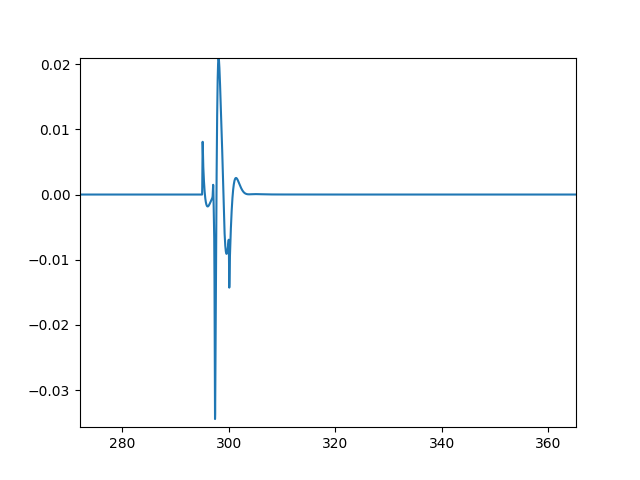

[0.015 0.3  ]


<IPython.core.display.Javascript object>


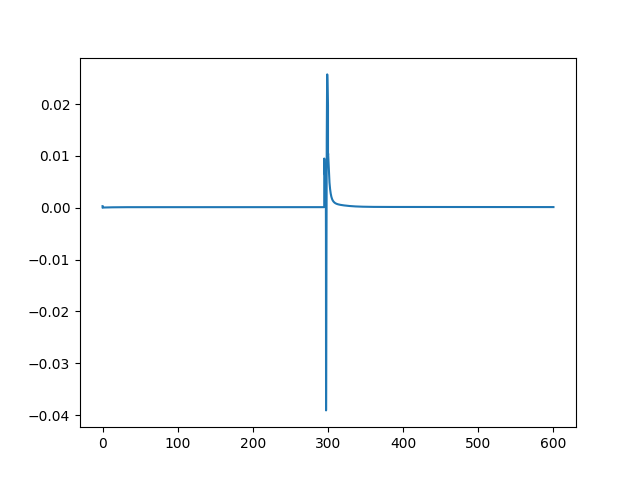

In [153]:
plt.figure()
plt.plot(LFPy_response['bAP.MEA.LFP']['time'], filter_data(LFPy_response['bAP.MEA.LFP'])[0]) 

plt.figure()
plt.plot(LFPy_response['bAP.MEA.LFP']['time'], LFPy_response['bAP.MEA.LFP']['voltage'][0])

In [ ]:
import efel

trace1 = {}
trace1['T'] = LFPy_response['Step3.soma.v']['time']
trace1['V'] = LFPy_response['Step3.soma.v']['voltage']
trace1['stim_start'] = [fitness_protocols['Step3'].stimuli[0].step_delay]
trace1['stim_end'] = [fitness_protocols['Step3'].stimuli[0].step_delay + 
                      fitness_protocols['Step3'].stimuli[0].step_duration]
traces = [trace1]
peaks = efel.getFeatureValues(traces, ['peak_time'])

<IPython.core.display.Javascript object>


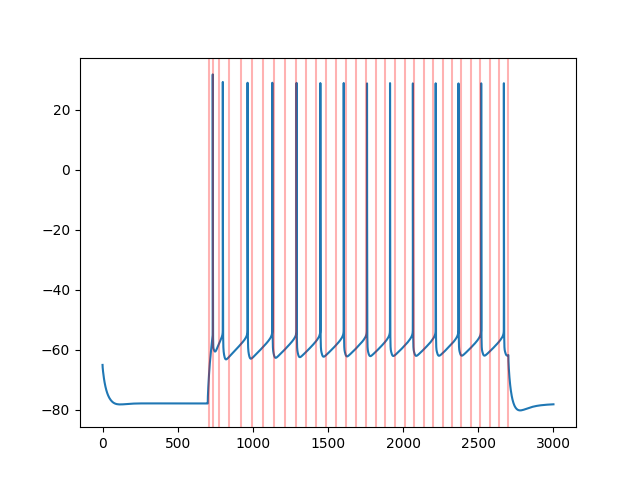

In [73]:
plt.figure()
plt.plot(LFPy_response['Step1.soma.v']['time'], LFPy_response['Step1.soma.v']['voltage'])

for p in peaks[0]['peak_time']:
    plt.axvline(p, color='r', alpha=0.3)

<IPython.core.display.Javascript object>


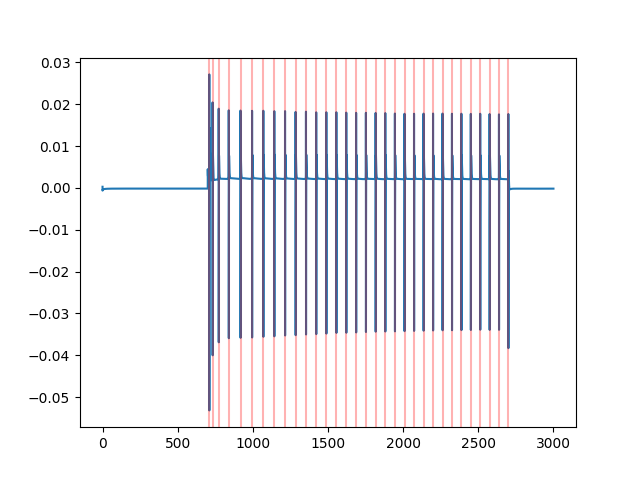

In [55]:
plt.figure()
plt.plot(LFPy_response['Step3.MEA.LFP']['time'], LFPy_response['Step3.MEA.LFP']['voltage'][0])

for p in peaks[0]['peak_time']:
    plt.axvline(p, color='r', alpha=0.3)

<IPython.core.display.Javascript object>


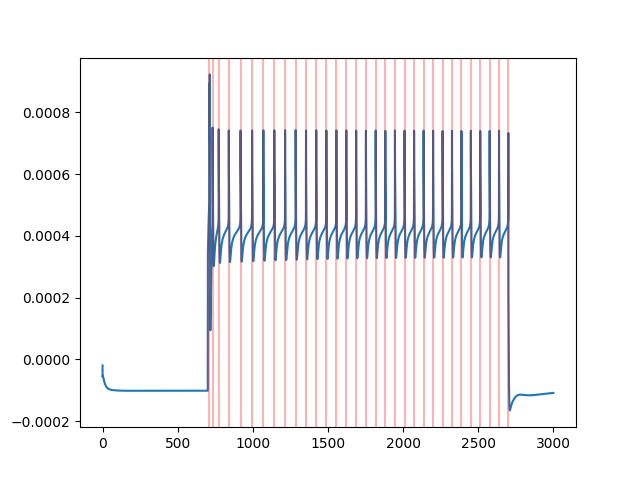

In [56]:
plt.figure()
plt.plot(LFPy_response['Step3.MEA.LFP']['time'], LFPy_response['Step3.MEA.LFP']['voltage'][1])

for p in peaks[0]['peak_time']:
    plt.axvline(p, color='r', alpha=0.3)

<IPython.core.display.Javascript object>


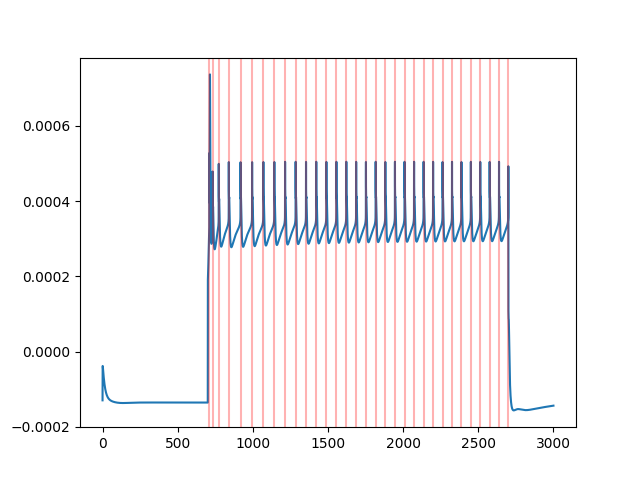

In [57]:
plt.figure()
plt.plot(LFPy_response['Step3.MEA.LFP']['time'], LFPy_response['Step3.MEA.LFP']['voltage'][2])

for p in peaks[0]['peak_time']:
    plt.axvline(p, color='r', alpha=0.3)

In [43]:
peaks

[{'peak_time': array([ 710.6,  732.5,  773.2,  840.1,  918.3,  995.3, 1070.1, 1143.1,
         1214.6, 1284.8, 1353.9, 1422. , 1489.4, 1556. , 1622. , 1687.5,
         1752.6, 1817.2, 1881.6, 1945.6, 2009.3, 2072.8, 2136.2, 2199.3,
         2262.3, 2325.2, 2387.9, 2450.5, 2513.1, 2575.6, 2637.9, 2700.3])}]

In [53]:
np.mean(np.diff(LFPy_response['Step3.soma.v']['time']))

0.024999999999928378

In [ ]:
plt.figure()
plt.plot(LFPy_responses['bAP.soma.v']['voltage'])
plt.plot(LFPy_responses['bAP.dend1.v']['voltage'])
plt.plot(LFPy_responses['bAP.dend2.v']['voltage'])

In [ ]:
LFPy_responses

In [ ]:
import pickle
original_responses = pickle.load(open("responses.pkl", "rb"))

fig, axes = plt.subplots(len(original_responses), figsize=(10,10))
for index, (resp_name, response) in enumerate(sorted(original_responses.items())):
    axes[index].plot(response['time'], response['voltage'], label=resp_name, lw=1.0, alpha=0.5)
    axes[index].plot(LFPy_responses[resp_name]['time'], LFPy_responses[resp_name]['voltage'], label=resp_name, lw=1.0, alpha=0.5)
    axes[index].set_title(resp_name)
fig.tight_layout()

for resp_name in original_responses:
    end = numpy.min([len(original_responses[resp_name]['time']), len(LFPy_responses[resp_name]['time'])])
    _ = numpy.sum(numpy.abs(original_responses[resp_name]['time'][:end]-LFPy_responses[resp_name]['time'][:end]))
    print(resp_name, _/end)
    print(LFPy_responses[resp_name]['time'].iloc[-1], original_responses[resp_name]['time'].iloc[-1])
fig.show()

In [ ]:
fig, axes = plt.subplots(len(original_responses), figsize=(10,10))
for index, (resp_name, response) in enumerate(sorted(original_responses.items())): 
        
        diff = numpy.diff(original_responses[resp_name]['time'])
        axes[index].plot(original_responses[resp_name]['time'][:-1], diff, lw=1.0, alpha=0.7)
        
        diff = numpy.diff(LFPy_responses[resp_name]['time'])
        axes[index].plot(LFPy_responses[resp_name]['time'][:-1], diff, lw=1.0, alpha=0.7)
        
        axes[index].set_xlabel("Time (ms)")
        axes[index].set_ylabel("dt (ms)")

In [ ]:
import neuroplotlib as npl

In [ ]:
cell = LFPy.Cell('morphology/C060114A7.asc')

In [ ]:
ax = npl.plot_neuron(cell, plane='xy', col_soma='r')

In [ ]:
mu.plot_probe(probe, ax=ax)

In [ ]:
probe.positions